In [1]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from d2l import torch as d2l
import numpy as np
import argparse
import datetime
import wandb 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 后面还要做混淆矩阵

# 参数解析器
parser = argparse.ArgumentParser()
parser.add_argument('--project_name', type=str, default='DSC_CNN_demo02', help='project_name')
parser.add_argument('--batch_size', type=int, default=32, help='size of each image batch')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--optim_type', type=str, default='Adam', help='Optimizer')
parser.add_argument('--epochs', type=int, default=100, help='epochs')
parser.add_argument('--model_pth_name', type=str, default='../save/model_default.pth', help='pth_name')
# 不会解析命令行参数
args = parser.parse_args([])
# 返回一个NameSpace对象

def create_input_iamge(data, length):
    # num = data.size//(length**2)
    # data = data[:num*(length**2)].reshape((num, 1, length, length))
    data = torch.tensor(data, dtype=torch.float32)
    return data

def create_dataloaders(length, Data_names, Data_names_key, Labels, data_path, is_train=1, batch_size = args.batch_size):
    for i in range(len(Data_names)):
        print('正在读取：' + Data_names[i])
        list_X = scipy.io.loadmat(data_path + Data_names[i])
        tensor_X = create_input_iamge(list_X[Data_names_key[i]], length)
        tensor_X = tensor_X.permute(0, 3, 1, 2)
        tensor_y = torch.full((tensor_X.shape[0],), Labels[i], dtype=torch.int64)
        print('tensor 形状：', tensor_X.shape)
        if i==0:
            X = tensor_X
            y = tensor_y
        else:
            # dim是轴而不是方向i
            X = torch.cat([X, tensor_X], dim=0)
            y = torch.cat([y, tensor_y], dim=0)
    print('模型输入的 tensor 形状为：', X.shape)
    print('对应标签的 tensor 形状为：', y.shape)
    
    dataset = TensorDataset(X, y)
    if is_train:
        train_size = int(0.7 * len(dataset))
        val_size = len(dataset) - train_size
        # 随机73划分数据集
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        # Dataloader类型具有__iter__()方法，在迭代时会返回一个迭代器
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )
        return train_dataloader, val_dataloader
    
    else:
        infer_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            drop_last=True
        )
        return infer_dataloader

正在读取：L_4
tensor 形状： torch.Size([273, 3, 224, 224])
模型输入的 tensor 形状为： torch.Size([273, 3, 224, 224])
对应标签的 tensor 形状为： torch.Size([273])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(2)


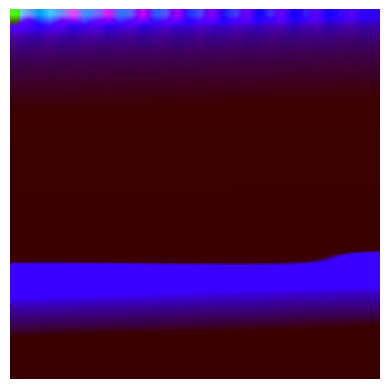

In [16]:
# Data_names = ['N_4']
# Data_names_key = ['all_data']
# Labels = [0]

# Data_names = ['H_4']
# Data_names_key = ['all_data']
# Labels = [4]

Data_names = ['L_4']
Data_names_key = ['all_data']
Labels = [2]

# Data_names = ['N_4', 'H_4', 'L_4']
# Data_names_key = ['all_data', 'all_data', 'all_data']
# Labels = [0, 1, 2]

train_dataloader, val_dataloader = create_dataloaders(64, Data_names, Data_names_key, Labels, '../data/new/')
# 在train中已被包含，这里仅作演示

'''
验证及查看数据
'''
import torch
import matplotlib.pyplot as plt

index = 31
for batch_X, batch_y in train_dataloader:
    print(batch_X.shape)
    print(batch_y[index])
    # 调整张量形状，去除多余维度
    image = batch_X[index,:].permute(2, 1, 0)
    break

# 显示特征图
plt.imshow(image)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [3]:
import torch
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# 定义Fire模块
class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(FireModule, self).__init__()
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.squeeze(x)
        x = torch.relu(x)
        return torch.cat([
            torch.relu(self.expand1x1(x)),
            torch.relu(self.expand3x3(x))
        ], 1)

# 定义卷积神经网络
class DSC_CNN(nn.Module):
    def __init__(self):
        super(DSC_CNN, self).__init__()
        # 修改输入通道数为 3
        self.layer1 = DepthwiseSeparableConv(3, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire = FireModule(32, 16, 32)
        self.concat_conv = DepthwiseSeparableConv(64, 64)  # 64 because FireModule output is concatenated
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # 推理时默认不会调用
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 3)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.fire(x)
        x = self.concat_conv(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # 改动1：避免softmax重复计算
        # x = self.softmax(x)
        return x

In [4]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    for step, batch in enumerate(dataloader):
        features, labels = batch
        features, labels = features.to(device),labels.to(device)

        preds = model(features)
        loss = nn.CrossEntropyLoss()(preds,labels)        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    return loss, model

def eval_epoch(model, dataloader):
    model.eval()
    accurate = 0
    num_elems = 0
    loss = 0
    num_batches = 0
    for batch in dataloader:
        features,labels = batch
        features,labels = features.to(device),labels.to(device)
        with torch.no_grad():
            preds = model(features)
        loss_batch = nn.CrossEntropyLoss()(preds, labels)
        loss += loss_batch
        num_batches += 1
        predictions = preds.argmax(dim=-1)
        accurate_preds = (predictions==labels)
        num_elems += accurate_preds.shape[0]
        accurate += accurate_preds.long().sum()# bool值转化为long
        
    val_acc = accurate.item() / num_elems
    loss = loss / num_batches
    return val_acc, loss

def train(args = args):
    Data_names = ['N_4', 'H_4', 'L_4']
    Data_names_key = ['all_data', 'all_data', 'all_data']
    Labels = [0, 1, 2]
    train_dataloader, val_dataloader = create_dataloaders(64, Data_names, Data_names_key, Labels, '../data/new/')
    
    model = DSC_CNN()
    model.to(device)
    optimizer = torch.optim.__dict__[args.optim_type](params=model.parameters(), lr=args.lr)
    #======================================================================
    # nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # wandb.init(project=args.project_name, config = args.__dict__, name = nowtime, save_code=True)
    # model.run_id = wandb.run.id
    #======================================================================    
    # model.best_metric = -1.0
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(1,args.epochs+1):
        train_loss, model = train_epoch(model, train_dataloader, optimizer)
        val_acc, val_loss = eval_epoch(model, val_dataloader)
        train_loss_list.append(train_loss.item())
        val_loss_list.append(val_loss.item())
        val_acc_list.append(val_acc)
        # if val_acc > model.best_metric:
        #     model.best_metric = val_acc
        #     torch.save(model.state_dict(),config.ckpt_path)   
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if epoch % 10 == 0:
            print(f"epoch【{epoch}】@{nowtime} --> val_acc= {100 * val_acc:.2f}%")
        
        #======================================================================
        # wandb.log({'train_loss':train_loss, 'val_loss':val_loss, 'val_acc': val_acc})
        #======================================================================        
    # print(train_loss_list, val_loss_list, val_acc_list)
    d2l.plot(list(range(1, args.epochs + 1)), [train_loss_list, val_loss_list, val_acc_list],
         xlabel='epoch', ylabel='loss', xlim=[1, args.epochs], ylim=[0, 1.2],
         legend=['train_loss', 'valid_loss', 'valid_acc'], yscale='linear')
    
    torch.save(model.state_dict(), args.model_pth_name)
    # wandb.finish()
    return model

正在读取：N_4
tensor 形状： torch.Size([273, 3, 224, 224])
正在读取：H_4
tensor 形状： torch.Size([273, 3, 224, 224])
正在读取：L_4
tensor 形状： torch.Size([273, 3, 224, 224])
模型输入的 tensor 形状为： torch.Size([819, 3, 224, 224])
对应标签的 tensor 形状为： torch.Size([819])
epoch【10】@2025-04-22 18:46:12 --> val_acc= 60.71%
epoch【20】@2025-04-22 18:46:22 --> val_acc= 67.86%
epoch【30】@2025-04-22 18:46:33 --> val_acc= 72.77%
epoch【40】@2025-04-22 18:46:44 --> val_acc= 79.46%
epoch【50】@2025-04-22 18:46:55 --> val_acc= 87.05%
epoch【60】@2025-04-22 18:47:06 --> val_acc= 87.50%
epoch【70】@2025-04-22 18:47:17 --> val_acc= 87.50%
epoch【80】@2025-04-22 18:47:28 --> val_acc= 88.84%
epoch【90】@2025-04-22 18:47:39 --> val_acc= 90.18%
epoch【100】@2025-04-22 18:47:50 --> val_acc= 91.52%
epoch【110】@2025-04-22 18:48:01 --> val_acc= 88.84%
epoch【120】@2025-04-22 18:48:11 --> val_acc= 88.39%
epoch【130】@2025-04-22 18:48:22 --> val_acc= 88.39%
epoch【140】@2025-04-22 18:48:33 --> val_acc= 89.73%
epoch【150】@2025-04-22 18:48:44 --> val_acc= 91.07%
epoch【

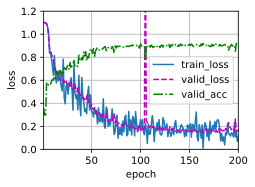

In [7]:
args.epochs = 200
args.batch_size = 8
args.lr = 0.001
args.optim_type = 'Adam'
model = train(args)